In [1]:
import os
import matplotlib.pyplot as plt
plt.rc('font', family='NanumGothic')
import torch
from torchvision import transforms
from torch.utils.data import Dataset, random_split, DataLoader
from PIL import Image
import torchvision.transforms.functional as TF
import numpy as np
from tqdm import tqdm
import re

# 증강

In [2]:
# 이미지를 회전시키는 함수
def rotate_images(image):
    images = []
    for angle in [0, 90, 180, 270]:
        rotated_image = TF.rotate(image, angle)
        images.append(rotated_image)
    return images

# 이미지에 가우시안 노이즈를 추가하는 함수
def gauss_noise(image_tensor, sigma=0.05):
    noise = torch.randn(image_tensor.size()) * sigma
    noisy_image = image_tensor + noise
    noisy_image = torch.clamp(noisy_image, 0, 1)
    return noisy_image

# 사용자 정의 데이터셋 클래스
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None, gauss_sigma=0.05):
        self.root_dir = root_dir
        self.transform = transform
        self.gauss_sigma = gauss_sigma
        self.images = self.make_dataset()

    # 데이터셋을 만드는 함수
    def make_dataset(self):
        images = []
        for class_name in sorted(os.listdir(self.root_dir)):
            class_dir = os.path.join(self.root_dir, class_name)
            if not os.path.isdir(class_dir):
                continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                images.append(img_path)
        return images
        
    def __len__(self):
        return len(self.images)
    
    # 데이터셋에서 아이템을 가져오는 함수
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            original_image = self.transform(image)  # 원본 이미지에 변환 적용
            noisy_image = gauss_noise(original_image, self.gauss_sigma)  # 가우시안 노이즈 추가
            rotated_images = rotate_images(image)  # 이미지 회전
            transformed_images = [self.transform(img) for img in rotated_images]  # 회전 이미지에 변환 적용
            noisy_images = [gauss_noise(img, self.gauss_sigma) for img in transformed_images]  # 회전 이미지에 노이즈 추가
            
            combined_images = [original_image, noisy_image] + transformed_images + noisy_images
            return combined_images
        else:
            return image


In [3]:
img_size = 480
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [4]:
root_path = "D:\datacut"

customdataset = CustomDataset(root_dir=root_path, transform=transform)

<>:1: SyntaxWarning: invalid escape sequence '\d'
<>:1: SyntaxWarning: invalid escape sequence '\d'
C:\Users\pon kj\AppData\Local\Temp\ipykernel_80920\3916030769.py:1: SyntaxWarning: invalid escape sequence '\d'
  root_path = "D:\datacut"


In [5]:
len(customdataset)

502

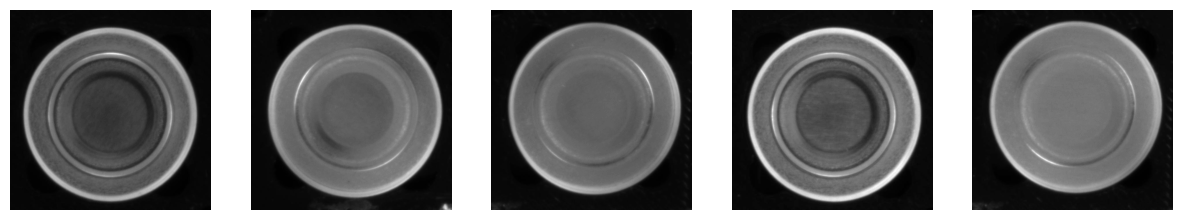

In [6]:
num_images = 5
indices = torch.randperm(len(customdataset))[:num_images]

plt.figure(figsize=(15, 5))
for i, idx in enumerate(indices):
    image = customdataset[idx]
    plt.subplot(1, num_images, i + 1)
    plt.imshow(image.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
plt.show()


In [9]:
train_size = int(len(customdataset) * 0.8)
val_size =  int(len(customdataset) - train_size)

train_dataset, val_dataset = random_split(customdataset, [train_size, val_size])

In [10]:
batch_size = 32
train_dl = DataLoader(train_dataset ,batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)